# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color
from matplotlib.colors import LinearSegmentedColormap
import importlib.util

# Create population grid

In [2]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

In [3]:
number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

# Create populations

In [4]:
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [f"pop {i+1}"]*c
populations = pd.DataFrame(labels_pop, columns=['populations'])


populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)

In [5]:
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

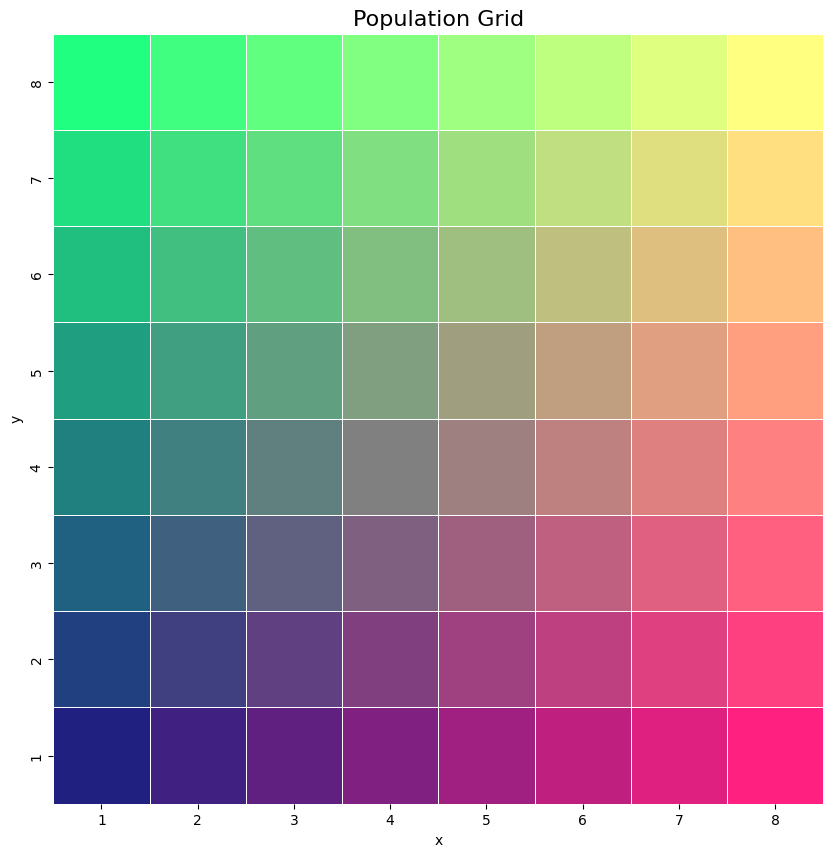

In [6]:
# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

In [7]:
os.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/", exist_ok = True)

In [8]:
populations[['populations', 'x', 'y', 'z']].to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

# Create genotypes based on AFs

In [9]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [10]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

In [11]:
try:
    true_p2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
    true_twopqs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
    true_q2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")
except:
    complete['pop'] = populations['population_number']
    
    p2s_dfs = []
    q2s_dfs = []
    twopqs_dfs = []
    
    for pop in list(populations['population_number'].unique()):
        snps = []
        p2s = []
        twopqs = []
        q2s = []
        temp = complete[complete['pop'] == pop].copy()
        temp = temp.drop("pop", axis=1)  # Use drop without inplace to avoid warnings
        for snp in list(temp.columns):
            try:
                num_maj = temp[[snp]].value_counts()[1]
            except Exception as e:
                num_maj = 0 
            try:
                num_het = temp[[snp]].value_counts()[0]
            except Exception as e:
                num_het = 0
            try:
                num_min = temp[[snp]].value_counts()[-1]
            except Exception as e:
                num_min = 0
            total_humans = num_maj + num_het + num_min
            p2 = [num_maj / total_humans] * total_humans
            twopq = [num_het / total_humans] * total_humans
            q2 = [num_min / total_humans] * total_humans
            p2s.append(p2)
            twopqs.append(twopq)
            q2s.append(q2)
            snps.append(snp)
        p2s = pd.DataFrame(p2s).T
        p2s.index = temp.index
        p2s.columns = snps
    
        twopqs = pd.DataFrame(twopqs).T
        twopqs.index = temp.index
        twopqs.columns = snps
    
        q2s = pd.DataFrame(q2s).T
        q2s.index = temp.index
        q2s.columns = snps
    
        p2s_dfs.append(p2s)
        twopqs_dfs.append(twopqs)
        q2s_dfs.append(q2s)
    
    complete = complete.drop("pop", axis=1)  # Use drop without inplace
    
    true_p2s = pd.concat(p2s_dfs)
    true_twopqs = pd.concat(twopqs_dfs)
    true_q2s = pd.concat(q2s_dfs)
    
    true_p2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
    true_twopqs.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
    true_q2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")


In [12]:
true_p2s

,CG2_AF_0.3015625,CG3_AF_0.36046875,CG6_AF_0.2903125,CG8_AF_0.5,CG10_AF_0.495625,CG11_AF_0.5,CG16_AF_0.36046875,CG18_AF_0.443125,CG19_AF_0.428125,CG21_AF_0.5,...,VRG1908_AF_0.0425,VRG1924_AF_0.0425,VRG1927_AF_0.02984375,VRG1933_AF_0.0425,VRG1939_AF_0.0425,VRG1943_AF_0.0425,VRG1980_AF_0.035,VRG1981_AF_0.0390625,VRG1984_AF_0.04203125,VRG1985_AF_0.049375
0,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.96,0.02,0.96,0.02,0.02,0.96,0.96,0.96,0.96,0.96
1,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.96,0.02,0.96,0.02,0.02,0.96,0.96,0.96,0.96,0.96
2,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.96,0.02,0.96,0.02,0.02,0.96,0.96,0.96,0.96,0.96
3,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.96,0.02,0.96,0.02,0.02,0.96,0.96,0.96,0.96,0.96
4,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.96,0.02,0.96,0.02,0.02,0.96,0.96,0.96,0.96,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,0.96,0.02,0.96,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96
3196,0.96,0.02,0.96,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96
3197,0.96,0.02,0.96,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96
3198,0.96,0.02,0.96,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96


In [13]:
true_q2s = 1-true_p2s.applymap(np.sqrt)
true_q2s['pop'] = populations['population_number']

/tmp/ipykernel_5030/3479264382.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  true_q2s = 1-true_p2s.applymap(np.sqrt)


In [14]:
pops = []
for pop in list(populations['population_number'].unique()):
    temp = true_q2s[true_q2s['pop'] == pop].copy()
    temp = temp.drop("pop", axis=1)  # Use drop without inplace to avoid warnings
    nr_individuals = len(temp)
    genotypes = []
    for snp in list(temp.columns):
        q = list(temp[snp])[0]
        p = 1-q
        freq_maj = p ** 2
        freq_het = 2 * p * q
        freq_min = q ** 2
        genotype = np.random.choice([1.0, 0.0, -1.0], size=nr_individuals, p=[freq_maj, freq_het, freq_min])
        genotypes.append(genotype)
    pop_geno = pd.DataFrame(genotypes).T
    pop_geno.columns = temp.columns
    pop_geno.index = temp.index
    pops.append(pop_geno)

complete = pd.concat(pops)

In [15]:
complete

,CG2_AF_0.3015625,CG3_AF_0.36046875,CG6_AF_0.2903125,CG8_AF_0.5,CG10_AF_0.495625,CG11_AF_0.5,CG16_AF_0.36046875,CG18_AF_0.443125,CG19_AF_0.428125,CG21_AF_0.5,...,VRG1908_AF_0.0425,VRG1924_AF_0.0425,VRG1927_AF_0.02984375,VRG1933_AF_0.0425,VRG1939_AF_0.0425,VRG1943_AF_0.0425,VRG1980_AF_0.035,VRG1981_AF_0.0390625,VRG1984_AF_0.04203125,VRG1985_AF_0.049375
0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,...,1.0,0.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0
2,-1.0,-1.0,0.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0
3,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,1.0,-1.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,0.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3196,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3197,1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3198,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [16]:
# to check the mafs
mafs = []
for snp_id in list(complete.columns):
    try:
        num_maj = complete[[snp_id]].value_counts()[1.0]
    except Exception as e:
        print(e)
        num_maj = 0
    try:
        num_het = complete[[snp_id]].value_counts()[0.0]
    except Exception as e:
        num_het = 0
    try:
        num_min = complete[[snp_id]].value_counts()[-1.0]
    except Exception as e:
        num_min = 0
    total_humans = num_maj + num_het + num_min
    maf = (num_min*2 + num_het)/(total_humans*2)
    mafs.append(maf)

In [17]:
simulated_genotype = complete+1
simulated_genotype = simulated_genotype.astype(int)

In [18]:
simulated_genotype

,CG2_AF_0.3015625,CG3_AF_0.36046875,CG6_AF_0.2903125,CG8_AF_0.5,CG10_AF_0.495625,CG11_AF_0.5,CG16_AF_0.36046875,CG18_AF_0.443125,CG19_AF_0.428125,CG21_AF_0.5,...,VRG1908_AF_0.0425,VRG1924_AF_0.0425,VRG1927_AF_0.02984375,VRG1933_AF_0.0425,VRG1939_AF_0.0425,VRG1943_AF_0.0425,VRG1980_AF_0.035,VRG1981_AF_0.0390625,VRG1984_AF_0.04203125,VRG1985_AF_0.049375
0,0,0,0,0,1,0,0,0,1,0,...,2,1,2,0,0,2,2,2,2,2
1,0,0,0,0,0,0,0,0,0,0,...,2,0,2,0,0,2,2,2,2,2
2,0,0,1,0,1,0,2,1,0,0,...,2,0,2,0,0,2,2,2,2,2
3,0,0,0,1,0,0,0,0,0,0,...,2,0,2,1,1,1,2,2,2,2
4,0,1,0,0,0,0,1,1,1,0,...,2,0,2,0,0,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,2,0,2,0,0,2,1,0,1,0,...,2,2,2,2,2,2,2,2,2,2
3196,2,0,2,0,0,0,0,1,1,1,...,2,2,2,2,2,2,2,2,2,2
3197,2,0,2,0,0,0,1,0,1,0,...,2,2,2,2,2,2,2,2,2,2
3198,2,1,2,0,0,0,0,1,0,1,...,2,2,2,2,2,2,2,2,2,2


In [19]:
# calculate when AF is > 0.5 and change the genotype
# Initialize a dictionary to store allele frequencies
allele_frequencies = {}

# Calculate allele frequencies for each SNP column
for snp in simulated_genotype.columns:
    total_alleles = 2 * len(simulated_genotype[snp])  # Total number of alleles (2 alleles per sample)
    minor_allele_count = (2 * simulated_genotype[snp].value_counts().get(0, 0)) + simulated_genotype[snp].value_counts().get(1, 0)
    allele_frequency = minor_allele_count / total_alleles
    allele_frequencies[snp] = allele_frequency

In [20]:
temp = simulated_genotype.T
temp['AFs'] = allele_frequencies

In [21]:
# Function to flip 0s to 2s and 2s to 0s
def flip_genotypes(row):
    if row['AFs'] > 0.5:
        # Apply transformation for the condition
        row[:-1] = row[:-1].replace({0: 2, 2: 0})
        row['AFs'] = 1 - row['AFs']  # Adjust allele frequency
    return row

# Apply the function across the DataFrame, row-wise
df_transformed = temp.apply(flip_genotypes, axis=1)

In [22]:
simulated_genotype = df_transformed.drop('AFs', axis=1).T
columns_to_drop  = simulated_genotype.columns[simulated_genotype.nunique() == 1] # If double columns delete it 
simulated_genotype = simulated_genotype.drop(columns=columns_to_drop)
simulated_genotype

,CG2_AF_0.3015625,CG3_AF_0.36046875,CG6_AF_0.2903125,CG8_AF_0.5,CG10_AF_0.495625,CG11_AF_0.5,CG16_AF_0.36046875,CG18_AF_0.443125,CG19_AF_0.428125,CG21_AF_0.5,...,VRG1908_AF_0.0425,VRG1924_AF_0.0425,VRG1927_AF_0.02984375,VRG1933_AF_0.0425,VRG1939_AF_0.0425,VRG1943_AF_0.0425,VRG1980_AF_0.035,VRG1981_AF_0.0390625,VRG1984_AF_0.04203125,VRG1985_AF_0.049375
0,2.0,2.0,0.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,...,2.0,1.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
1,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
2,2.0,2.0,1.0,2.0,1.0,2.0,0.0,1.0,2.0,2.0,...,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
3,2.0,2.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0
4,2.0,1.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,...,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,0.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3196,0.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3197,0.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3198,0.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [23]:
very_rare = temp[(temp['AFs'] > very_rare_threshold_L) & (temp['AFs'] <= very_rare_threshold_H)]
very_rare.index = very_rare.index.str.split('_AF_').str[0]
very_rare.index = 'G'+very_rare.index.str.split('G').str[1]
very_rare

,0,1,2,3,4,5,6,7,8,9,...,3191,3192,3193,3194,3195,3196,3197,3198,3199,AFs
G480,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,0.048906
G41,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,1,2,2,0.042969
G44,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,0.036406
G55,2,2,2,2,2,2,2,2,2,2,...,1,2,2,2,2,2,2,1,2,0.037500
G68,2,2,2,2,2,2,1,2,2,2,...,2,2,2,2,1,2,2,2,2,0.043750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G1880,2,2,2,2,2,2,2,2,2,2,...,2,1,2,2,1,2,2,2,2,0.034844
G1886,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,1,2,2,0.040156
G1896,2,2,2,2,2,2,2,2,2,2,...,2,2,2,1,2,2,2,2,2,0.045000
G1927,2,2,2,2,2,2,2,2,2,1,...,2,2,2,2,2,2,2,2,2,0.036719


In [24]:
very_rare = temp[(temp['AFs'] > very_rare_threshold_L) & (temp['AFs'] <= very_rare_threshold_H)]
very_rare.index = very_rare.index.str.split('_AF_').str[0]
very_rare.index = 'G'+very_rare.index.str.split('G').str[1]

rare = temp[(temp['AFs'] > rare_threshold_L) & (temp['AFs'] <= rare_threshold_H)]
rare.index = rare.index.str.split('_AF_').str[0]
rare.index = 'G'+rare.index.str.split('G').str[1]

common = temp[(temp['AFs'] > common_threshold_L) & (temp['AFs'] <= common_threshold_H)]
common.index = common.index.str.split('_AF_').str[0]
common.index = 'G'+common.index.str.split('G').str[1]

very_rare['snps'] = very_rare.index + '_AF_' + very_rare['AFs'].astype(str)
very_rare.set_index('snps', inplace=True)
very_rare_to_save = very_rare.drop('AFs', axis=1).T
very_rare_afs = very_rare[['AFs']]

rare['snps'] = rare.index + '_AF_' + rare['AFs'].astype(str)
rare.set_index('snps', inplace=True)
rare_to_save = rare.drop('AFs', axis=1).T
rare_afs = rare[['AFs']]

common['snps'] = common.index + '_AF_' + common['AFs'].astype(str)
common.set_index('snps', inplace=True)
common_to_save = common.drop('AFs', axis=1).T
common_afs = common[['AFs']]

/tmp/ipykernel_5030/2149441337.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  very_rare['snps'] = very_rare.index + '_AF_' + very_rare['AFs'].astype(str)
/tmp/ipykernel_5030/2149441337.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rare['snps'] = rare.index + '_AF_' + rare['AFs'].astype(str)
/tmp/ipykernel_5030/2149441337.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [25]:
very_rare_to_save.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare_to_save.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common_to_save.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [26]:
os.system(f"rm data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
os.system(f"rm data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
os.system(f"rm data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")

0

In [27]:
very_rare_to_save = very_rare_to_save.rename(columns=lambda x: 'VR' + x)/2
rare_to_save = rare_to_save.rename(columns=lambda x: 'R' + x)/2
common_to_save = common_to_save.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common_to_save, rare_to_save, very_rare_to_save], axis=1)
complete = ((complete*2)-1)
complete

snps,CG6_AF_0.49828125,CG37_AF_0.47828125,CG59_AF_0.34671875,CG69_AF_0.36609375,CG74_AF_0.40625,CG84_AF_0.44546875,CG92_AF_0.3703125,CG93_AF_0.4865625,CG96_AF_0.3734375,CG101_AF_0.45015625,...,VRG1736_AF_0.044375,VRG1762_AF_0.0453125,VRG1778_AF_0.04796875,VRG1803_AF_0.0353125,VRG1865_AF_0.0446875,VRG1880_AF_0.03484375,VRG1886_AF_0.04015625,VRG1896_AF_0.045,VRG1927_AF_0.03671875,VRG1980_AF_0.0440625
0,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,-1.0,0.0,1.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,-1.0,-1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3196,1.0,-1.0,-1.0,0.0,1.0,1.0,0.0,0.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3197,1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,-1.0,-1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3198,1.0,-1.0,0.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
complete['pop'] = populations['population_number']

p2s_dfs = []
q2s_dfs = []
twopqs_dfs = []

for pop in list(populations['population_number'].unique()):
    snps = []
    p2s = []
    twopqs = []
    q2s = []
    temp = complete[complete['pop'] == pop].copy()
    temp = temp.drop("pop", axis=1)  # Use drop without inplace to avoid warnings
    for snp in list(temp.columns):
        try:
            num_maj = temp[[snp]].value_counts()[1.0]
        except Exception as e:
            num_maj = 0 
        try:
            num_het = temp[[snp]].value_counts()[0.0]
        except Exception as e:
            num_het = 0
        try:
            num_min = temp[[snp]].value_counts()[-1.0]
        except Exception as e:
            num_min = 0
        total_humans = num_maj + num_het + num_min
        p2 = [num_maj / total_humans] * total_humans
        twopq = [num_het / total_humans] * total_humans
        q2 = [num_min / total_humans] * total_humans
        p2s.append(p2)
        twopqs.append(twopq)
        q2s.append(q2)
        snps.append(snp)
    p2s = pd.DataFrame(p2s).T
    p2s.index = temp.index
    p2s.columns = snps

    twopqs = pd.DataFrame(twopqs).T
    twopqs.index = temp.index
    twopqs.columns = snps

    q2s = pd.DataFrame(q2s).T
    q2s.index = temp.index
    q2s.columns = snps

    p2s_dfs.append(p2s)
    twopqs_dfs.append(twopqs)
    q2s_dfs.append(q2s)

complete = complete.drop("pop", axis=1)  # Use drop without inplace

true_p2s = pd.concat(p2s_dfs)
true_twopqs = pd.concat(twopqs_dfs)
true_q2s = pd.concat(q2s_dfs)

true_p2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/true_p2_via_true_pop.pkl")
true_twopqs.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/true_twopq_v bia_true_pop.pkl")
true_q2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/true_q2_via_true_pop.pkl")
